In [101]:
import numpy as np
import time 
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from scipy.stats import qmc, norm
from scipy.optimize import minimize
from typing import Iterator, List, Tuple, Union

from science_jubilee.Machine import Machine
from science_jubilee.tools.Tool import Tool
from science_jubilee.decks.Deck import Deck
from science_jubilee.labware.Labware import Labware, Location, Well
from science_jubilee.tools.Pipette import Pipette
from science_jubilee.bo.newcamera2 import Cam

from skimage import color

**Set the Deck, Labware, Camera, Pipette for manual experiment**

In [61]:
deck = Deck("lab_automation_deck") # We are not using the deck, so operate any deck.json 
tiprack = deck.load_labware(labware_filename = 'opentrons_96_tiprack_1000ul', slot = 5)   # Load an opentrons 20uL
tiprack.manual_offset([[265.2, 214.5],[166.3, 214.5],[166.3, 277.7]], save = True)   # Save through list of list. List of coordinates should be A1 A12 H12 subsequently. 
#tiprack.manual_offset([[269, 221.6],[170, 221.6],[170, 284.6]], save = True)
trash = deck.load_labware('agilent_1_reservoir_290ml.json', 0)
samples = deck.load_labware('corning_24_wellplate_3.4ml_flat', slot = 2)
samples.manual_offset([[124.7, 120.7],[29.9, 120.7], [29.9, 176.7]], save = True)
stocks = deck.load_labware('corning_6_wellplate_16.8ml.json', slot = 3)
stocks.manual_offset([[255.9, 131.6], [176.9, 131.6], [176.9, 170.6]], save = True)
#camera_well = deck.load_labware("cam_wellplate_96.json", slot = 2)
camera_well = deck.load_labware("updated_cam_wellplate_24.json", slot = 2)

New manual offset applied to opentrons_96_tiprack_1000ul
Manual offset saved
New manual offset applied to corning_24_wellplate_3.4ml_flat
Manual offset saved
New manual offset applied to corning_6_wellplate_16.8ml_flat
Manual offset saved


## **Connect Axo.Jubilee** ##

In [62]:
axo = Machine(address = "192.168.1.4")
axo.home_all()

In [102]:
axo.move_to(z=180)

In [64]:
deck = axo.load_deck("lab_automation_deck")
tiprack = axo.load_labware("opentrons_96_tiprack_1000ul", 5)
tiprack.load_manualOffset()
trash = axo.load_labware('agilent_1_reservoir_290ml.json', 1)
#pipette = Pipette(0, "Pipette", brand = "opentron", model = "config", max_volume= 20, min_volume= 0, zero_position = (0,0,0),\
#    blowout_position=None, drop_tip_position = None, mm_to_ul = None)# model = "config")
samples = axo.load_labware('corning_24_wellplate_3.4ml_flat', 2)
samples.load_manualOffset()
stocks = axo.load_labware('corning_6_wellplate_16.8ml.json', 3)
stocks.load_manualOffset()
# camera_well = axo.load_labware("cam_wellplate_96.json", slot = 2)
camera_well = axo.load_labware("updated_cam_wellplate_24.json", slot = 2)

New manual offset applied to opentrons_96_tiprack_1000ul
New manual offset applied to corning_24_wellplate_3.4ml_flat
New manual offset applied to corning_6_wellplate_16.8ml_flat


In [103]:
# Load the camera tool, Pipette
P20 = Pipette.from_config(0, 'Pipette', 'P300_config.json')
#camera = Cam(1, "Camera", '192.168.1.2', 'Sun92023', 'axo', 'C:/science-jubilee/axo/bodata', light=True, light_pin= 0)
camera = Cam(1, "Camera", '192.168.1.2', 'C:/science-jubilee/axo/bodata/3-3-2025', 50, light= True, light_pin = 0)
axo.load_tool(camera)
axo.load_tool(P20)
P20.add_tiprack(tiprack)
P20.trash = trash[0]

## **Color Demo ( BO )** ## 

## **Functions** ##


In [104]:
# Visualization of selected colors
def visualize_color_selection(X_samples, target_color):
    n_samples = len(X_samples)
    colors_per_row = 10
    n_rows = (n_samples + colors_per_row - 1) // colors_per_row

    plt.figure(figsize=(12, n_rows * 1.2))
    for idx, rgb in enumerate(X_samples):
        row = idx // colors_per_row
        col = idx % colors_per_row

        plt.subplot(n_rows, colors_per_row, idx + 1)
        plt.imshow([[rgb / 255.0]], extent=[0, 1, 0, 1])
        plt.axis("off")
        plt.title(f"Iter {idx + 1}", fontsize=8)

    plt.tight_layout()
    plt.figure(figsize=(2, 2))
    plt.imshow([[target_color / 255.0]], extent=[0, 1, 0, 1])
    plt.axis("off")
    plt.title("Target Color", fontsize=12)
    plt.show()

# To visualize one color and target color 
def visualize_one_color(X_sample, target_color, index):
    plt.figure(figsize=(4, 2))
    
    # Plot the sample color
    plt.subplot(1, 2, 1)
    plt.imshow([[X_sample / 255.0]], extent=[0, 1, 0, 1])
    plt.axis("off")
    plt.title(f"Iter {index + 1}", fontsize=12)
    
    plt.subplot(1, 2, 2)
    plt.imshow([[target_color / 255.0]], extent=[0, 1, 0, 1])
    plt.axis("off")
    plt.title("Target Color", fontsize=12)
    plt.tight_layout()
    plt.show()
    

# To visualize one color and target color 
def visualize_two_color(X_sample, real_color, target_color, index):
    plt.figure(figsize=(4, 2))
    plt.title(f"iter {index+1}")
    # Plot the sample color
    plt.subplot(1, 3, 1)
    plt.imshow([[X_sample / 255.0]], extent=[0, 1, 0, 1])
    plt.axis("off")
    plt.title(f"Proposed_RGB", fontsize=12)
    
    plt.subplot(1, 3, 2)
    plt.imshow([[real_color / 255.0]], extent=[0, 1, 0, 1])
    plt.axis("off")
    plt.title(f"Actual RGB", fontsize=12)
    
    plt.subplot(1, 3, 3)
    plt.imshow([[target_color / 255.0]], extent=[0, 1, 0, 1])
    plt.axis("off")
    plt.title("Target Color", fontsize=12)
    plt.tight_layout()
    plt.show()

In [111]:
def latin_hypercube_sampling(n_samples, bounds):
    """
    Generates sample points using Latin Hypercube Sampling (LHS).

    Parameters:
        n_samples : int
            Number of samples to generate.
        bounds : list or array-like of tuples
            List of (min, max) pairs for each dimension.
            e.g., [(0, 255), (0, 255), (0, 255)] for RGB.

    Returns:
        samples : ndarray of shape (n_samples, d)
            The generated sample points.
    """
    d = len(bounds)
    samples = np.zeros((n_samples, d))

    # For each dimension, create n_samples stratified intervals and randomly sample within each interval.
    for i in range(d):
        low, high = bounds[i]
        # Create equally spaced intervals in [0,1]
        intervals = np.linspace(0, 1, n_samples + 1)
        # Sample one point uniformly from each interval.
        temp = np.random.uniform(low=intervals[:-1], high=intervals[1:], size=n_samples)
        # Shuffle the samples to ensure random pairing across dimensions.
        np.random.shuffle(temp)
        # Scale the samples to the bounds for dimension i.
        samples[:, i] = low + temp * (high - low)

    return samples


# ------------------------------------------------
# 3. Orthogonal Sampling
# ------------------------------------------------
def orthogonal_sampling(n_samples, bounds):
    """
    Generates sample points using Orthogonal Sampling.

    The idea is to divide each dimension into equal subdivisions (cells) so that the space is
    partitioned into a grid. Then, a subset of the grid cells is chosen randomly (if necessary)
    and one random point is sampled uniformly from each selected cell.

    Parameters:
        n_samples : int
            Number of samples to generate.
        bounds : list or array-like of tuples
            List of (min, max) pairs for each dimension.
            e.g., [(0, 255), (0, 255), (0, 255)] for RGB.

    Returns:
        samples : ndarray of shape (n_samples, d)
            The generated sample points.
    """
    d = len(bounds)
    # Determine the number of divisions per dimension.
    divisions = int(np.ceil(n_samples ** (1.0 / d)))
    total_cells = divisions ** d

    # Generate all possible cell indices as a grid.
    grid_axes = [np.arange(divisions) for _ in range(d)]
    grid = np.array(np.meshgrid(*grid_axes)).T.reshape(-1, d)

    # Randomly choose n_samples unique cells.
    if n_samples > total_cells:
        raise ValueError("n_samples exceeds the total number of available cells in the grid.")
    chosen_cells = grid[np.random.choice(total_cells, n_samples, replace=False)]

    samples = np.zeros((n_samples, d))
    for i in range(d):
        low, high = bounds[i]
        cell_size = (high - low) / divisions
        # For each chosen cell in dimension i, compute the lower bound and add a random offset.
        cell_lower = low + chosen_cells[:, i] * cell_size
        samples[:, i] = cell_lower + np.random.uniform(0, cell_size, n_samples)

    return samples

In [112]:
# Function to normalize RGB values
def normalize(v, bounds):
    lower = bounds[:,0]
    upper = bounds[:,1]
    #return (rgb / 255.0).astype(float)
    return (v - lower) / (upper - lower)
# Function to denormalize RGB values
def denormalize(v, bounds):
    lower = bounds[:, 0]
    upper = bounds[:, 1]
    #return (rgb * 255.0).astype(float)
    return v * (upper - lower) + lower


In [113]:
# Function to normalize RGB values
def normalize_rgb(rgb):
    return rgb / 255.0

# Function to denormalize RGB values
def denormalize_rgb(rgb):
    return (rgb * 255.0).astype(int)

In [114]:
def color_objective(rgb, target_rgb=(128, 128, 128)):
    """
    Computes the squared Euclidean distance between a candidate RGB value and a target RGB value.

    Parameters:
        rgb : array-like
            Candidate RGB value, e.g., [R, G, B] with each value in [0, 255].
        target_rgb : tuple (default: (128, 128, 128))
            The target RGB value.

    Returns:
        float : Squared Euclidean distance between rgb and target_rgb.
    """
    rgb = np.array(rgb, dtype=np.float64)
    target = np.array(target_rgb, dtype=np.float64)
    return np.sum((rgb - target)**2)

In [ ]:
def color_objective_ciedelta(rgb, target_rgb=(128, 128, 128)):
    """
    Computes the CIE ΔE color difference between a candidate RGB value and a target RGB value
    using scikit-image's color conversion and ΔE calculation functions.

    Parameters:
        rgb : array-like
            Candidate RGB value, e.g., [R, G, B] with each value in [0, 255].
        target_rgb : tuple, optional
            The target RGB value (default is (128, 128, 128)).

    Returns:
        float : The CIE ΔE color difference between the candidate and target colors.
    """
    def rgb_to_lab(rgb_value):
        # Normalize to [0, 1] and reshape to (1, 1, 3) for skimage
        #rgb_norm = np.array(rgb_value, dtype=np.float64) / 255.0
        rgb_norm = rgb_value.reshape((1, 1, 3))
        lab = color.rgb2lab(rgb_norm)
        return lab[0, 0, :]
    
    lab1 = rgb_to_lab(rgb)
    lab2 = rgb_to_lab(target_rgb)
    # scikit-image's deltaE_ciede2000 expects arrays of shape (..., 3)
    delta_e = color.deltaE_ciede2000(np.array([lab1]), np.array([lab2]))[0]
    return delta_e

## **Color Mixing + Optimization + Camera** ##

In [116]:
def denormalize_volume_vector(v, max_vol):
    """
    Normalizes a 1D volume vector so that its entries are nonnegative
    and sum to 1000 µL.
    
    Parameters:
        v (array-like): Raw candidate volume vector. (normalized)
        max_vol : int
    Returns:
        np.ndarray: A volume vector that sums to 1000.
    """
    v = np.maximum(v, 0)  # Ensure no negative volumes.
    
    total_row = np.sum(v, axis = -1, keepdims = True) # Sum along the last axis
    return max_vol * v / total_row

### **Axo-Jubilee reads the locations from Labware class Well, Location, Tuple**  ###
### **Assign as dictionary for initial samples, additional iterations after intial samples, and maps them to samples and camera target location.** ###

In [117]:
# Assign all the labware for experimental settings 
# This is for 96 tipracks and 24 wells
def assign_wells_and_targets(max_iterations, n_initial_samples, tiprack: Well, samples: Well, camera_well : Well, plate_rows=4, plate_cols=6):
    """
    Assigns wells for initial samples, additional iterations after inital samples, 
    and maps them to samples target location and camera target location.
    Assigned Tipracks' value contains list of list as (initial_samples, 5)
    Args:
        max_iterations (int): Total number of iterations for the experiment.
        n_initial_samples (int): Number of initial samples.
        plate_rows (int): Number of rows in the plate layout (default: 8 for a 96-well plate).
        plate_cols (int): Number of columns in the plate layout (default: 12 for a 96-well plate).
        samples (dict): Mapping of well names to sample locations.
        camera_well (dict): Mapping of well names to camera locations.
    
    Returns:
        dict: A dictionary containing:
            - 'initial_wells': List of wells for initial samples.
            - 'additional_wells': List of wells for additional iterations.
            - 'target_wells': Combined list of all target wells.
            - 'well_targets': List of sample locations corresponding to target wells.
            - 'camera_targets': List of camera locations corresponding to target wells.
    """
    # Generate plate layout
    plate_layout = [f"{chr(row)}{col}" for row in range(ord('A'), ord('A') + plate_rows) for col in range(1, plate_cols + 1)]
    
    # Allocate wells for the first n_initial_samples
    initial_wells = plate_layout[:n_initial_samples]
    initial_tipracks_wells = plate_layout[:n_initial_samples*5]
    
    initial_tipracks = [
        [tiprack[well] for well in initial_tipracks_wells[i * 5:(i + 1) * 5]] 
        for i in range(n_initial_samples)
    ]
    initial_wells_target = [samples[well] for well in initial_wells] 
    initial_camera_wells_target = [camera_well[well] for well in initial_wells]
    
    # Assign remaining wells for iterations
    additional_tipracks_wells = plate_layout[len(initial_tipracks_wells):(len(initial_tipracks_wells) + max_iterations*4)]
    additional_wells = plate_layout[len(initial_wells):(len(initial_wells) + max_iterations)]
    
    # Map to well targets and camera targets
    additional_tipracks = [
        [tiprack[well] for well in additional_tipracks_wells[i * 5:(i + 1) * 5]] 
        for i in range(max_iterations)
    ]
    well_targets = [samples[well] for well in additional_wells] if samples else []
    camera_targets = [camera_well[well] for well in additional_wells] if camera_well else []
    
    return {
        'initial_tipracks': initial_tipracks,
        'initial_wells': initial_wells_target,
        'initial_camera_wells': initial_camera_wells_target,
        'additional_tipracks': additional_tipracks,
        'well_targets': well_targets,
        'camera_targets': camera_targets
    }

# Example
max_iterations = 10
n_initial_samples = 2
sample_volume = 160
target_rgb = np.array([10, 157, 200]) 

result = assign_wells_and_targets(max_iterations, n_initial_samples, tiprack= tiprack, samples = samples, camera_well = camera_well)

print(result['additional_tipracks'][0])

[Well B5 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5, Well B6 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5, Well C1 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5, Well C2 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5, Well C3 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5]


# **Demo-Run Color-Mixing Bayesian Optimization** #

In [119]:
### Initialize stocks and define parameters
max_iterations = 19 # BO iterations
n_initial_samples = 1  # Initial samples
sample_volume = 1000 # Volume of Samples for each wells
#target_rgb = np.array([10, 10, 154])  # Target RGB color
bounds = np.array([[0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000]])
norm_bounds = np.array([[0, 1], [0, 1], [0, 1], [0, 1], [0, 1]])
rgb_bounds = np.array([[0, 255], [0, 255], [0, 255]])

In [126]:
camera.start_video_stream_server()
axo.pickup_tool(camera)

Video stream server is already running.


In [127]:
target_image_data = camera.capture_image(camera_well['D6'], light= True, light_intensity= 1.0)
target_image, target_rgb = camera.detect_and_draw_wells(target_image_data)
target_rgb = np.array([target_rgb['R'], target_rgb['G'], target_rgb['B']]).reshape(-1)
axo.park_tool()

In [128]:
print(target_rgb)

[ 42.41061721 118.72957052  52.88049083]


Text(0.5, 1.0, 'Target_RGB')

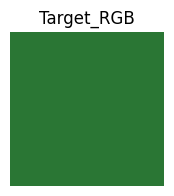

In [129]:
plt.figure(figsize=(4, 2))
plt.subplot(1, 1, 1)
plt.imshow([[target_rgb / 255.0]], extent=[0, 1, 0, 1])    
plt.axis("off")
plt.title(f"Target_RGB", fontsize=12)

In [ ]:
### Bayesian Optimization Setup
# Define kernel explicitly
# UPDATE  REASONING FOR KERNEL SELECTION 
kernel = RBF(length_scale=5.0) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-6, 1e-3)) # white kernel is for adding noise

# , length_scale_bounds=(1e-3, 1e3)
# Surrogate Model
# Initialize Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-4, n_restarts_optimizer=10, normalize_y=True)


# Acquisition Function
# Acquisition Function
# Expected Improvement maximizes implicitly
# ei[sigma == 0.0] = 0.0 VERIFY HOW EI WORKS IN THIS CODE
def expected_improvement(X, X_sample, y_sample, model, xi = 0.1):
    """Return the expected improvement.
    Arguments
    mu     -- The predictive mean at the test points.
    sigma -- The predictive standard deviation at
             the test points.
    ymax  -- The maximum observed value (so far).
    """
    mu, sigma = model.predict(X, return_std=True)
    sigma = sigma.reshape(-1, 1)
    optimal_sample = np.min(y_sample)

    with np.errstate(divide="ignore"):
        imp = optimal_sample - mu - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        #print(f"Expected Improvements : {ei}")
        ei[sigma == 0.0] = 0.0
    return ei.flatten()

def upper_confidence_bound(X, model, beta=0.1):
    """
    Computes the acquisition value using the UCB criterion adapted for minimization.

    For minimization, one common approach is to consider the lower confidence bound:
         LCB(x) = mu(x) - beta * sigma(x)
    We then define an acquisition value as the negative LCB so that we can maximize it.

    Parameters:
        X : ndarray, shape (n, d)
            Points where UCB should be evaluated.
        gp : GaussianProcessRegressor
            A Gaussian Process fitted to samples.
        beta : float
            Controls the trade-off between exploration and exploitation.

    Returns:
        ucb : ndarray, shape (n, 1)
            Acquisition value (to be maximized) at points X.
    """
    mu, sigma = model.predict(X, return_std=True)
    print(f"Sampled point Uncertainty gives : {sigma}")
    # For minimization, lower mu - beta*sigma is better.
    # By returning its negative, we set up a maximization problem.
    ucb = -(mu - beta * sigma)
    return ucb

# NOTE MAKE SURE WHY ALGORITHM IS NOT RESAMPLING at each ITERATION
# Function to propose the next sample point using Expected Improvement
# Make sure it doesn't resample the same x each iterations
def propose_location(acquisition, X_sample, y_sample, model, bounds, n_restarts=25, acq_kwargs = {}):
    dim = X_sample.shape[1]

    # Convert bounds to a NumPy array
    bounds = np.array(bounds)  # FIX: Convert list of tuples to array
    
    def min_obj(x):
        return -acquisition(x.reshape(-1, dim), X_sample, y_sample, gp, **acq_kwargs)

    # Starting points for optimization
    x0_list = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim))
    
    # Use Latin Hypercube Sampling (LHS) for better spread in the search space
    #sampler = qmc.LatinHypercube(d=dim)
    #x0_list = qmc.scale(sampler.random(n=50), bounds[:, 0], bounds[:, 1])
    # work in the normalized space
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    mix_x, min_val = None, float("inf")
    for x0 in x0_list:
        res = minimize(min_obj, x0, bounds=bounds, constraints=cons, method='SLSQP')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x
    return min_x

In [144]:
def color_mover(volumes, target_well: Union[Well, Tuple, Location], tip_rack: Union[Well, Tuple, Location], tip_index: int):
    """
    Dispenses color components (e.g., Cyan, Magenta, Yellow, Black) into the target well using a pipette.
    Makes One color well. 
    Args:
        volumes (dict): Dictionary specifying the volumes of each color component to be aspirated and dispensed.
                        Keys are color names (e.g., "Cyan", "Magenta", "Yellow", "Black"), and values are volumes (float).
        target_well (Union[Well, Tuple, Location]): The well where the mixed components will be dispensed.

    Returns:
        The function performs physical operations with no return value.
    """
    
    axo.pickup_tool(P20)
    
    color_keys = ["Cyan", "Magenta", "Yellow", "Black", "White"]
    volumes = {color : vol for color, vol in zip(color_keys, volumes)}
    
    stock_positions = {"Cyan": "A1", "Magenta": "A2", "Yellow": "A3", "Black": "B1", "White": "B2"}
        
    print(f"Asipirating {volumes}")
    # Define stock positions for Red, Green, Blue
    for color, volume in volumes.items():
        
        if color == "Cyan":
            stock_position = stock_positions["Cyan"]
        elif color == "Magenta":
            stock_position = stock_positions["Magenta"]
        elif color == "Yellow":
            stock_position = stock_positions["Yellow"]
        elif color == "Black":
            stock_position = stock_positions["Black"]
        else:
            stock_position = stock_positions["White"]
        
        #if volume > 0:
        #    P20.pickup_tip(tip_rack[idx])
        #else:
        #    continue
        if volume < 30:
            continue  # Skip aspiration but remember the last used tip
        
        if tip_index >= len(tip_rack.wells):
            raise IndexError("No more available tips in the tip rack")
        tip_location = tip_rack[tip_index]
        P20.pickup_tip(tip_location)
        tip_index += 1 # Move to the next tip for the next color
        
        print(f"Picked up new tip: {tip_location}")
        # If transfer doesn't work well, change to the previous one  
        # Verified it didn't work, moving back and forth to stocks and samples is not working  
        #P20.transfer(volume, stock_position, target_well.top(-4), blowout = True, new_tip = 'once', mix_after = )
        #seperated_value = amount_to_aspirate(volume)
        #print(f"Dispensing {color} with {seperated_value}uL")
        
        #for value in seperated_value:
            # We use the same stock colors at each iterations
            # Add aspiration function from the stock location
        P20.aspirate(vol = volume, location = stocks[stock_position], s = 4000)
            # Add dispensing function to the well plate 
        P20.dispense(vol = volume, location = target_well, s = 4000)
            
        time.sleep(2)
        #P20.mix(vol = 100, n=2)
            
        #P20.blowout(s = 3000) # Blowout keeps dropping the tips
        # Assign trash locations inside the class attribute (Later)    # HardCoded
        P20.drop_tip(trash[0])

    axo.park_tool()

    return tip_index

def process_camera(camera_well: Union[Well, Tuple, Location]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Captures an image from a specified well using the camera and extracts RGB values.

    Args:
        camera_well (Union[Well, Tuple, Location]): The well location to capture the image and extract RGB data.

    Returns:
        Tuple[np.ndarray, list]:
            - image (np.ndarray): The captured image as a NumPy array.
            - extract_rgb (list): List of dictionaries containing RGB values, e.g., [{"R": 120, "G": 200, "B": 150}].
    """
   
    axo.pickup_tool(camera)

    # Capture the image of the well
    image = camera.capture_image(camera_well, light=True, light_intensity = 1.0)
    
    # capture image again for stabilizing image
    #for _ in range(2):
    #    image = camera.take_picture()
        
    masked_image, extract_rgb = camera.detect_and_draw_wells(image)
    # extract_rgb is already denormalized
    
    axo.park_tool()

    return masked_image, extract_rgb

# color_mover + process_camera
# Attach Pipette and move to the stock and make samples according to the decision
def color_maker(volumes: np.ndarray, 
                sample_volume: float, 
                target_well: Union[Well, Tuple, Location], 
                camera_target_well: Union[Well, Tuple, Location], 
                tip_rack: List[Union[Well, Tuple, Location]],
                tip_index : int
                ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Mixes colors based on the given RGB values, dispenses into the target well, and captures an image to analyze the resulting RGB.
    The Function performs color_mover and process_camera functionality.

    Args:
        rgb (np.ndarray): RGB values to mix. Shape: (3,). Normalized RGB
        sample_volume (float): Total volume of the sample to be dispensed into the target well.
        target_well (Union[Well, Tuple, Location]): The well where the mixed color sample will be dispensed.
        camera_target_well (Union[Well, Tuple, Location]): The well location to capture and process RGB data using the camera.

    Returns:
        Tuple[np.ndarray, np.ndarray]:
            - image (np.ndarray): Captured image of the well after color mixing.
            - rgb_array (np.ndarray): Extracted and normalized RGB values from the image. Shape: (n_samples, 3).
    """
    
    
    
    # volumes = calculate_volumes_cmyk(rgb, sample_volume)
    
    # Mix colors using the pipette       
    tip_index = color_mover(volumes, target_well, tip_rack, tip_index)
    
    # Capture circled masked image of resulting color in the well and extract rgb 
    masked_image, rgb_results = process_camera(camera_target_well)

    # Extract RGB values into a NumPy array
    rgb_array = np.array([rgb_results['R'], rgb_results['G'], rgb_results['B']]).reshape(-1)
    
    return masked_image, rgb_array, tip_index

def decision_maker(target_rgb,
                   surrogate_model, 
                   acquisition_function,
                   sample_volume, 
                   X_sample, 
                   y_sample,
                   rgb_sample,
                   target_wells: List[Union[Well, Location, Tuple]],
                   camera_target_wells: List[Union[Well, Location, Tuple]],
                   tip_rack: Union[Well, Location, Tuple],
                   initial_tip_index : int, # Start from last used tip after initial samples
                   bounds = np.array([[0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000],]),
                   norm_bounds = np.array([[0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]), 
                   max_iterations = 10) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform multiple iterations of Bayesian Optimization, sampling different wells for each iteration.
    Args:
        target_rgb: Target RGB value to optimize towards. Target RGB should be normalized
        surrogate_model: Model called from the sklearn package (Gaussian Process Regressor)
        acquisition_function: The acquisition function to use for Bayesian Optimization.
        sample_volume: The sample volume for color mixing.
        X_sample: The current set of sample points.
        y_sample: The current set of objective values for the samples.
        target_wells: A list of target wells for each iteration.
        bounds: Bounds for the optimization space.
        max_iterations: Maximum number of iterations to perform.
    Returns:
        Updated X_sample and y_sample with all iterations completed.
    """
    
    # assert len(target_wells) >= max_iterations, "Insufficient target wells for the given number of iterations."
    
    tip_index = initial_tip_index
    
    initial = len(X_sample)
    # Run optimization loop for all iterations
    for iteration in range(max_iterations):
        # Propose the next location to sample
        
        if acquisition_function == 'ucb':
            # Upper confience bound
            x_next_norm = propose_location(
            lambda X, X_sample, Y_sample, gp, **kwargs: upper_confidence_bound(X, gp, **kwargs),
            X_sample,
            y_sample,
            gp,
            norm_bounds,
            n_restarts=10,
            acq_kwargs={'beta': 0.1}  # Adjust beta to control exploration (lower means less exploration)
            )
        
        elif acquisition_function == 'ei':
        ## Expected improvement
            x_next_norm = propose_location(
            lambda X, X_sample, Y_sample, gp, **kwargs: expected_improvement(X, X_sample, Y_sample, gp, **kwargs),
            X_sample,
            y_sample,
            gp,
            norm_bounds,
            n_restarts=10,
            acq_kwargs={'xi': 0.1}  # Adjust beta to control exploration (lower means less exploration)
            )
        #next_sample = propose_location(acquisition_function, X_sample, y_sample, bounds)
    
        # Denormalize next_sample to evaluate 
        
        
        #next_sample_denorm = denormalize_rgb(x_next_norm, bounds)
        # Normalize the candidate so that its 4 volumes sum to 1000 µL.
        volumes = denormalize_volume_vector(x_next_norm, sample_volume)
        # Visualization for which color is sampled from acquuisition function
        # Get the target well for this iteration
        current_target_well = target_wells[iteration]
        current_camera_well = camera_target_wells[iteration]
        # current_tipracks = tip_rack[iteration]
        
        # Make colors and extract actual RGB values
        image, rgb_val, tip_index = color_maker(
            volumes=volumes, 
            sample_volume=sample_volume, 
            target_well=current_target_well,
            camera_target_well=current_camera_well,
            tip_rack= tip_rack,
            tip_index=tip_index
        )
        
        print(f"Actual RGB value : {rgb_val}")
        
        visualize_one_color(rgb_val, target_rgb, initial + iteration)
        # Normalize Acutal RGB Values
        rgb_val_normalized = normalize_rgb(rgb_val)
        
        # Evaluate the objective function (Simulation)
        y_next_norm = color_objective_ciedelta(rgb_val_normalized, normalize_rgb(target_rgb))
        
        # Append the new sample and its objective value
        rgb_sample = np.vstack((rgb_sample, rgb_val))
        X_sample = np.vstack((X_sample, x_next_norm))
        y_sample = np.append(y_sample, y_next_norm)
    
        # Update the Gaussian Process model after all iterations
        surrogate_model.fit(X_sample, y_sample)
    
    return X_sample, y_sample, rgb_sample, tip_index

In [132]:
# Initialize initial samples and distances with normalized values
# Normalize target color
normalized_target_rgb = normalize_rgb(target_rgb)
X_init_norm = orthogonal_sampling(n_initial_samples, norm_bounds)
# Evaluate the objective at initial points 
Y_init_norm = np.zeros(n_initial_samples)
rgb_samples = np.empty((0,3))
# Combine initial and additional wells
all_wells = assign_wells_and_targets(max_iterations, n_initial_samples, samples = samples, camera_well = camera_well, tiprack= tiprack)

# visualize_color_selection(denormalize_rgb(X_init_norm, bounds), target_rgb)

In [97]:
print(rgb_samples)

[]


Picking up tip from : Well A1 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Now aspirating Sample 1 to target_well: Well A1 form Corning 24 Well Plate 3.4 mL Flat on slot 2
Asipirating {'Cyan': np.float64(275.6046226881424), 'Magenta': np.float64(439.16549233966725), 'Yellow': np.float64(19.569827602252513), 'Black': np.float64(167.86874663363346), 'White': np.float64(97.79131073630444)}
Picked up new tip: Well A1 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well A2 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well A3 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well A4 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5


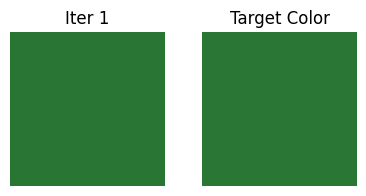

Actual_rgb detected: [ 41.9651803  118.97163034  52.27229981]


GaussianProcessRegressor(alpha=0.0001,
                         kernel=RBF(length_scale=5) + WhiteKernel(noise_level=0.1),
                         n_restarts_optimizer=10, normalize_y=True)

In [133]:
# Initialize tip tracking
tip_index = 0  

# Run the colormixing for initial samples

for idx, x_sample in enumerate(X_init_norm): 
    target_well = all_wells['initial_wells'][idx]
    camera_target_well = all_wells['initial_camera_wells'][idx]
    # initial_tiprack = all_wells['initial_tipracks']  # Single list of 96 tips

    #denormalized_rgb = denormalize_rgb(x_sample, bounds)
    denormalized_volume = denormalize_volume_vector(x_sample, sample_volume)
    # Visualize the sampled color for each iteration
    #visualize_one_color(denormalized_rgb, target_rgb, idx)
    
    print(f"Picking up tip from : {tiprack[tip_index]}")
    print(f"Now aspirating Sample {idx+1} to target_well: {target_well}")
    
    # Run color mixing, capture image, and update tip index
    image, rgb, tip_index = color_maker(
        volumes=denormalized_volume, 
        sample_volume=sample_volume, 
        target_well=target_well, 
        camera_target_well=camera_target_well, 
        tip_rack=tiprack, 
        tip_index=tip_index
    )
    
    rgb_samples = np.vstack((rgb_samples, rgb))
    visualize_one_color(rgb, target_rgb, idx)
    #print(f"Proposed_rgb: {denormalized_rgb}")
    print(f"Actual_rgb detected: {rgb}")
    
    rgb_val_normalized = normalize_rgb(rgb)
    Y_next_norm = color_objective_ciedelta(rgb_val_normalized, normalize_rgb(target_rgb))
    
    Y_init_norm[idx] = Y_next_norm  # Update the distance

# Fit the GP model
gp.fit(X_init_norm, Y_init_norm)

In [134]:
print(Y_init_norm)

[0.17228923]


Asipirating {'Cyan': np.float64(39.947673973013735), 'Magenta': np.float64(4.1633363423443364e-14), 'Yellow': np.float64(229.63955737840348), 'Black': np.float64(0.0), 'White': np.float64(730.4127686485829)}
Picked up new tip: Well A5 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well A6 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well A7 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Actual RGB value : [120.09843542 139.03118823  76.74296198]


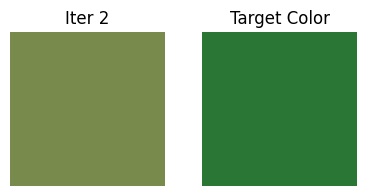

Asipirating {'Cyan': np.float64(0.0), 'Magenta': np.float64(2.7755575615628914e-14), 'Yellow': np.float64(171.96459271617437), 'Black': np.float64(638.629251488354), 'White': np.float64(189.4061557954716)}
Picked up new tip: Well A8 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well A9 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well A10 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Actual RGB value : [143.35746821 182.49943393 125.86559069]


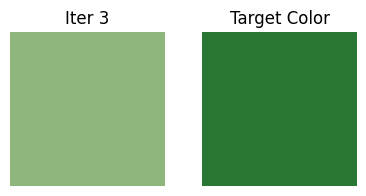

Asipirating {'Cyan': np.float64(169.4645820746149), 'Magenta': np.float64(5.551115123125779e-14), 'Yellow': np.float64(487.99300027507604), 'Black': np.float64(5.551115123125779e-14), 'White': np.float64(342.5424176503089)}
Picked up new tip: Well A11 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well A12 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well B1 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Actual RGB value : [112.07823885 125.88982895  52.04200563]


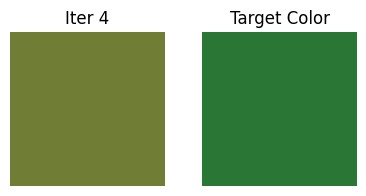

Asipirating {'Cyan': np.float64(314.90761677219365), 'Magenta': np.float64(624.6562295952909), 'Yellow': np.float64(1.247309310144972e-10), 'Black': np.float64(60.43615363239065), 'White': np.float64(0.0)}
Picked up new tip: Well B2 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well B3 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well B4 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Actual RGB value : [ 77.25750494 146.11074438  52.83923105]


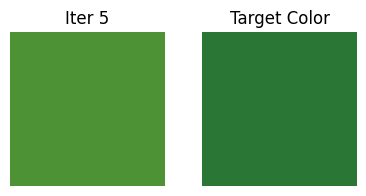

c:\Users\titan\anaconda3\envs\axo\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.001. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Asipirating {'Cyan': np.float64(271.76272688454566), 'Magenta': np.float64(538.0670807913606), 'Yellow': np.float64(1.2890771627154204e-07), 'Black': np.float64(190.17019219141886), 'White': np.float64(3.767368436256771e-09)}
Picked up new tip: Well B5 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well B6 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well B7 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Actual RGB value : [43.17274896 35.66575214 73.04865372]


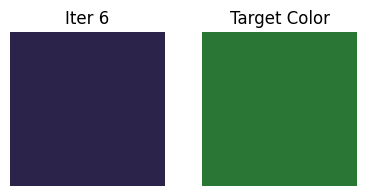

Asipirating {'Cyan': np.float64(328.99344115316467), 'Magenta': np.float64(311.3195865665783), 'Yellow': np.float64(274.324688858975), 'Black': np.float64(85.36228342128204), 'White': np.float64(0.0)}
Picked up new tip: Well B8 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well B9 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well B10 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well B11 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Actual RGB value : [79.72776529 74.04327685 89.11028084]


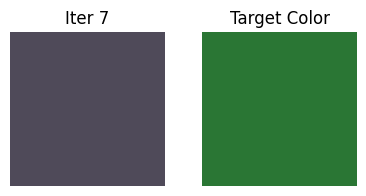

Asipirating {'Cyan': np.float64(0.0), 'Magenta': np.float64(422.24594535782546), 'Yellow': np.float64(372.8093482853692), 'Black': np.float64(0.0), 'White': np.float64(204.94470635680543)}
Picked up new tip: Well B12 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well C1 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well C2 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Actual RGB value : [60.3038479  60.96073511 43.04045055]


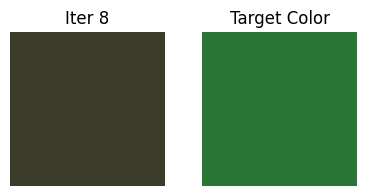

Asipirating {'Cyan': np.float64(0.0), 'Magenta': np.float64(0.0), 'Yellow': np.float64(228.55432372115186), 'Black': np.float64(221.9138594814319), 'White': np.float64(549.5318167974162)}
Picked up new tip: Well C3 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well C4 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well C5 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Actual RGB value : [131.23254935  96.33514317  46.41387738]


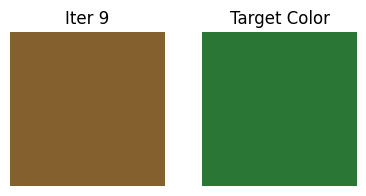

Asipirating {'Cyan': np.float64(0.0), 'Magenta': np.float64(1.3877787807814454e-14), 'Yellow': np.float64(815.1680879346399), 'Black': np.float64(140.04797111292527), 'White': np.float64(44.78394095243481)}
Picked up new tip: Well C6 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well C7 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well C8 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Actual RGB value : [142.98327698 168.40208826  70.96682277]


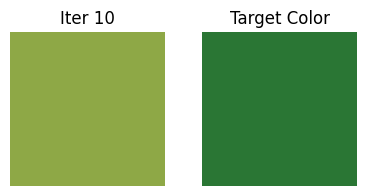

Asipirating {'Cyan': np.float64(0.0), 'Magenta': np.float64(482.2885958351865), 'Yellow': np.float64(436.27226314578576), 'Black': np.float64(81.43914101902773), 'White': np.float64(0.0)}
Picked up new tip: Well C9 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well C10 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well C11 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Actual RGB value : [149.6436351  183.19234894  72.89702975]


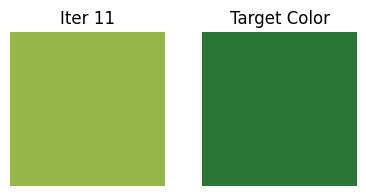

Asipirating {'Cyan': np.float64(240.3004898443946), 'Magenta': np.float64(0.0), 'Yellow': np.float64(242.7224903342896), 'Black': np.float64(433.85793095414965), 'White': np.float64(83.11908886716617)}
Picked up new tip: Well C12 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well D1 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well D2 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well D3 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Actual RGB value : [152.75913033 125.35791984 102.2957964 ]


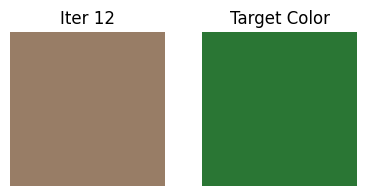

c:\Users\titan\anaconda3\envs\axo\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Asipirating {'Cyan': np.float64(0.0), 'Magenta': np.float64(524.6150714478332), 'Yellow': np.float64(8.326672684688673e-14), 'Black': np.float64(288.7740970388694), 'White': np.float64(186.61083151329734)}
Picked up new tip: Well D4 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well D5 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well D6 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Actual RGB value : [55.49172491 96.96842418 41.76847844]


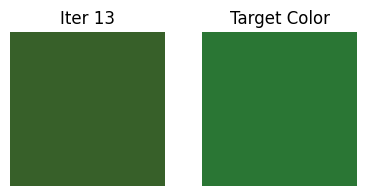

Asipirating {'Cyan': np.float64(301.0367490388817), 'Magenta': np.float64(5.551115123125783e-14), 'Yellow': np.float64(144.90752497391242), 'Black': np.float64(0.0), 'White': np.float64(554.0557259872058)}
Picked up new tip: Well D7 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well D8 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well D9 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Actual RGB value : [155.81931084 113.12439558 121.6419131 ]


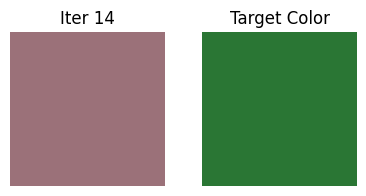

c:\Users\titan\anaconda3\envs\axo\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Asipirating {'Cyan': np.float64(0.0), 'Magenta': np.float64(0.0), 'Yellow': np.float64(392.136183566043), 'Black': np.float64(356.6547793467155), 'White': np.float64(251.20903708724157)}
Picked up new tip: Well D10 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well D11 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well D12 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Actual RGB value : [ 94.69233249 161.64194099  91.6303504 ]


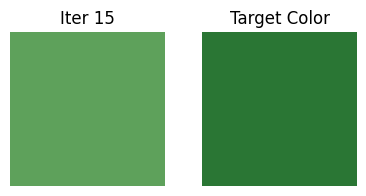

Asipirating {'Cyan': np.float64(418.6456391154925), 'Magenta': np.float64(2.775557561562892e-14), 'Yellow': np.float64(548.8438900106903), 'Black': np.float64(0.0), 'White': np.float64(32.51047087381726)}
Picked up new tip: Well E1 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well E2 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well E3 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Actual RGB value : [126.34808506 147.56754998  74.47384729]


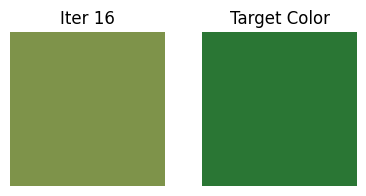

Asipirating {'Cyan': np.float64(287.8037777471896), 'Magenta': np.float64(276.2649964735922), 'Yellow': np.float64(32.0913893741855), 'Black': np.float64(217.04588558876205), 'White': np.float64(186.79395081627064)}
Picked up new tip: Well E4 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well E5 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well E6 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well E7 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well E8 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Actual RGB value : [ 39.81605769 105.72322143  45.43203396]


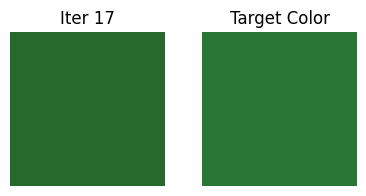

Asipirating {'Cyan': np.float64(1.1102230246251558e-13), 'Magenta': np.float64(5.551115123125779e-14), 'Yellow': np.float64(651.3949095677023), 'Black': np.float64(284.79729664662034), 'White': np.float64(63.80779378567715)}
Picked up new tip: Well E9 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well E10 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well E11 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Actual RGB value : [55.16211435 63.25496473 58.62514478]


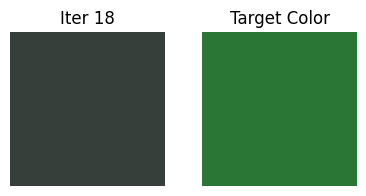

Asipirating {'Cyan': np.float64(0.0), 'Magenta': np.float64(343.8760107048761), 'Yellow': np.float64(259.98009798933765), 'Black': np.float64(75.8928130707817), 'White': np.float64(320.2510782350046)}
Picked up new tip: Well E12 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well F1 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well F2 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well F3 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Actual RGB value : [120.07699382 149.58640936  57.91369675]


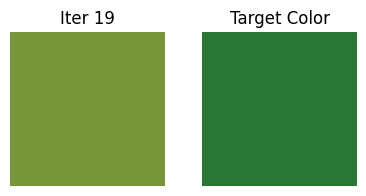

Asipirating {'Cyan': np.float64(0.0), 'Magenta': np.float64(364.22078149384936), 'Yellow': np.float64(0.0), 'Black': np.float64(252.91610438116027), 'White': np.float64(382.8631141249905)}
Picked up new tip: Well F4 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well F5 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Picked up new tip: Well F6 form Opentrons OT-2 96 Tip Rack 1000 µL on slot 5
Actual RGB value : [175.34218408 125.8124958   86.96136025]


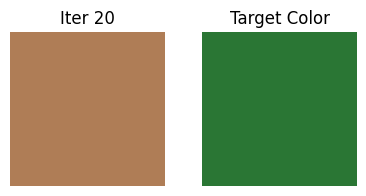

In [ ]:
# Now run Bayesian Optimization (BO) with the updated tip index
X_sample, y_sample, rgb_samples, tip_index = decision_maker(
    target_rgb = target_rgb, 
    surrogate_model=gp, 
    acquisition_function='ucb',
    sample_volume=sample_volume, 
    X_sample=X_init_norm, 
    y_sample=Y_init_norm,
    rgb_sample=rgb_samples,
    target_wells=all_wells['well_targets'],
    camera_target_wells=all_wells['camera_targets'],
    tip_rack=tiprack,  # Continue using additional tip racks
    initial_tip_index=tip_index,  # Start from where the initial samples left off
    bounds = bounds,
    norm_bounds = norm_bounds,
    max_iterations = 19
)

In [138]:
camera.stop_video_stream_server()

Video stream server stopped successfully.


In [139]:
print(X_sample)
print(y_sample)

[[4.94500486e-01 7.87967732e-01 3.51129425e-02 3.01196606e-01
  1.75460957e-01]
 [3.99476740e-02 4.16333634e-17 2.29639557e-01 0.00000000e+00
  7.30412769e-01]
 [0.00000000e+00 2.77555756e-17 1.71964593e-01 6.38629251e-01
  1.89406156e-01]
 [1.69464582e-01 5.55111512e-17 4.87993000e-01 5.55111512e-17
  3.42542418e-01]
 [3.14907617e-01 6.24656230e-01 1.24730931e-13 6.04361536e-02
  0.00000000e+00]
 [2.71762727e-01 5.38067081e-01 1.28907716e-10 1.90170192e-01
  3.76736844e-12]
 [3.28993441e-01 3.11319587e-01 2.74324689e-01 8.53622834e-02
  0.00000000e+00]
 [0.00000000e+00 4.22245945e-01 3.72809348e-01 0.00000000e+00
  2.04944706e-01]
 [0.00000000e+00 0.00000000e+00 2.28554324e-01 2.21913859e-01
  5.49531817e-01]
 [0.00000000e+00 1.38777878e-17 8.15168088e-01 1.40047971e-01
  4.47839410e-02]
 [0.00000000e+00 4.82288596e-01 4.36272263e-01 8.14391410e-02
  0.00000000e+00]
 [2.40300490e-01 0.00000000e+00 2.42722490e-01 4.33857931e-01
  8.31190889e-02]
 [0.00000000e+00 5.24615071e-01 8.326672

In [141]:
print(rgb_samples)

[[ 41.9651803  118.97163034  52.27229981]]


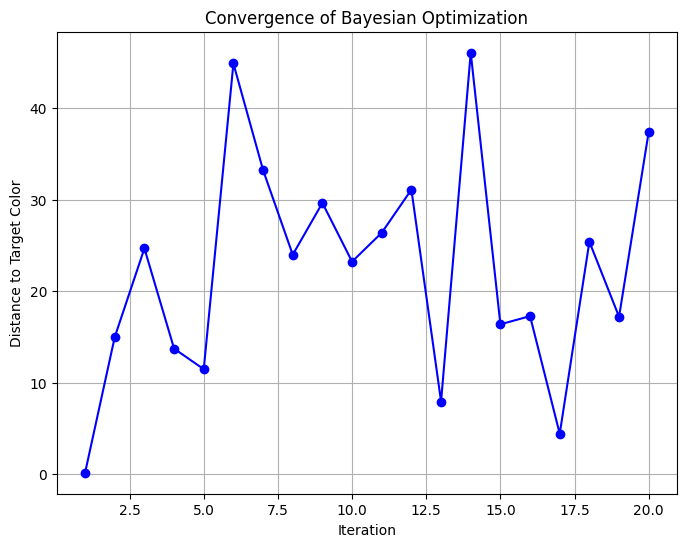

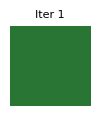

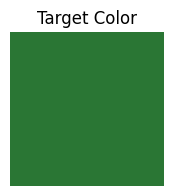

Optimal RGB: [126 200   8  76  44]
Closest distance to target color: 0.17228923042061808


In [140]:
X_sample_denorm = denormalize_rgb(X_sample)

# Visualization of results
# Plot convergence
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(y_sample) + 1), y_sample, marker='o', linestyle='-', color='b')
plt.title('Convergence of Bayesian Optimization')
plt.xlabel('Iteration')
plt.ylabel('Distance to Target Color')
plt.grid(True)
plt.show()

# Visualize the final selected colors
visualize_color_selection(rgb_samples, target_rgb)

# Display final results
optimal_rgb = X_sample_denorm[np.argmin(y_sample)]
print("Optimal RGB:", optimal_rgb)
print("Closest distance to target color:", np.min(y_sample))

In [142]:
import pandas as pd 
# Denormalize RGB values
X_sample_denorm = denormalize_volume_vector(X_sample, sample_volume)

# Convert data to DataFrame
df = pd.DataFrame(X_sample_denorm, columns=['C', 'M', 'Y', 'K', 'W'])
df['Distance'] = y_sample  # Convert back to positive distances
df['Iteration'] = range(1, len(y_sample) + 1)

# Find the optimal RGB and its corresponding distance
optimal_index = np.argmin(y_sample)
optimal_rgb = X_sample_denorm[optimal_index]
optimal_distance = np.min(y_sample)

df.loc[len(df)] = ['OPTIMAL', *optimal_rgb, optimal_distance]
# Append optimal values to DataFrame


# Save to CSV
df.to_csv("C:/science-jubilee/axo/bodata/result/optimization_results_7_ciedelta.csv", index=False)

In [27]:
# Results
axo.park_tool()

In [39]:
axo.pickup_tool(P20)

In [49]:
P20.pickup_tip(tiprack['C8'])
P20.return_tip(tiprack['C8'])

In [34]:
P20._dispense(vol=600)

In [44]:
P20._aspirate(vol=1000, s=800)

ToolStateError: Error: Tool Pipette is not the current `Active Tool`. Cannot perform this action

In [50]:
axo.pickup_tool(P20)

In [51]:
P20.pickup_tip(tiprack['A1'])

In [52]:
P20.return_tip(tiprack['A1'])

In [53]:
axo.park_tool()

In [338]:
axo.safe_z_movement()

In [14]:
P20.aspirate(vol = 500, location = stocks['A1'], s=4000)

In [ ]:
P20.dispense(vol = 500, location = samples['A1'], s=4000)


In [35]:
P20.drop_tip(trash[0])

In [ ]:
axo.move_to(z=180)

In [36]:
axo.park_tool()

In [17]:
axo.get_position()

{'X': '220.880',
 'Y': '48.580',
 'Z': '180.000',
 'U': '79.993',
 'V': '-100.000',
 'E': '0.000'}

In [63]:
axo.pickup_tool(camera)

In [41]:
camera.start_video_stream_server()

Server is not running. Starting it now...
Flask server started successfully.
Give 12 second to make camera stabilize


True

In [43]:
process_camera(all_wells['initial_camera_wells'][2])

Error or insufficient circles detected in blurred image: No valid circles detected in blurred image.. Retrying with binary image...


(array([[[251, 252, 248],
         [250, 251, 247],
         [247, 251, 245],
         ...,
         [254, 250, 255],
         [254, 250, 255],
         [254, 250, 255]],
 
        [[250, 251, 247],
         [248, 252, 247],
         [248, 252, 246],
         ...,
         [254, 250, 255],
         [254, 250, 255],
         [254, 250, 255]],
 
        [[247, 251, 246],
         [248, 252, 247],
         [248, 252, 246],
         ...,
         [254, 250, 255],
         [254, 250, 255],
         [254, 250, 255]],
 
        ...,
 
        [[253, 251, 240],
         [253, 251, 240],
         [252, 252, 240],
         ...,
         [254, 250, 255],
         [254, 250, 255],
         [254, 250, 255]],
 
        [[252, 252, 240],
         [252, 252, 240],
         [252, 252, 240],
         ...,
         [254, 250, 255],
         [254, 250, 255],
         [254, 250, 255]],
 
        [[252, 252, 240],
         [252, 252, 240],
         [252, 252, 240],
         ...,
         [254, 250, 255],
  

In [25]:
image_data = camera.capture_image(camera_well[4], light= True, light_intensity= 1.0)

In [49]:
print(camera_well[1])

Well A2 form Custom 24 Well Plate on slot 2


In [ ]:
x, y, z  = Labware._getxyz(camera_well[1])

In [51]:
axo.move_to(z=205)

In [66]:
x, y, _ = Labware._getxyz(camera_well['D6'])
x = x-14.3
y = y - 100.8
axo.move_to(x, y)
#axo.move_to(x=34.8, y=74.5)

In [117]:
for i in range(24):
    #image_data = camera.capture_image(camera_well[i], light= True, light_intensity= 0.5)
    x, y, _ = Labware._getxyz(camera_well[i])
    x = x-14.3
    y = y - 100.8
    axo.move_to(x, y)
    time.sleep(5)
    #image_data, rgb_results = camera.detect_and_draw_wells(image_data)

KeyboardInterrupt: 

In [15]:
image_data, rgb_results = camera.detect_and_draw_wells(image_data)

Error or insufficient circles detected in blurred image: No valid circles detected in blurred image.. Retrying with binary image...


In [74]:
print(rgb_results)

{'R': np.float64(95.91151199076647), 'G': np.float64(149.51535929551576), 'B': np.float64(96.90657889112127)}


In [60]:
import cv2 
 # Display the image
cv2.imshow("Image Display", image_data)

    # Wait for a key press to close the image window
cv2.waitKey(0)

    # Close all OpenCV windows
cv2.destroyAllWindows()

In [60]:
axo.park_tool()

In [270]:
axo.move_to(x=30.5, y=74.3)

In [29]:
Labware._getxyz(camera_well['A3'])

(127.28999999999999, 172.1, 3.5)

In [62]:
P20.drop_tip(trash[0])

In [39]:
axo.get_position()['V']

'-100.000'

In [ ]:
TARGET_RGB = np.array([])

In [98]:

def rgb_to_lab(rgb):
    """
    Convert an sRGB color (with components in [0, 255]) to CIELAB.
    Uses the D65 white reference.
    """
    # Normalize RGB to [0, 1]
    rgb = np.array(rgb, dtype=np.float64) / 255.0
    
    # Convert sRGB to linear RGB
    def to_linear(c):
        return c / 12.92 if c <= 0.04045 else ((c + 0.055) / 1.055) ** 2.4
    linear_rgb = np.array([to_linear(c) for c in rgb])
    
    # Convert linear RGB to XYZ using the standard sRGB matrix (D65)
    M = np.array([[0.4124564, 0.3575761, 0.1804375],
                  [0.2126729, 0.7151522, 0.0721750],
                  [0.0193339, 0.1191920, 0.9503041]])
    XYZ = np.dot(M, linear_rgb)
    
    # Normalize for D65 white point (using reference values for X, Y, Z)
    X, Y, Z = XYZ / np.array([0.95047, 1.00000, 1.08883])
    
    # Helper function for XYZ -> Lab conversion
    def f(t):
        delta = 6/29
        return t ** (1/3) if t > delta**3 else (t / (3 * delta**2) + 4/29)
    
    fX, fY, fZ = f(X), f(Y), f(Z)
    L = 116 * fY - 16
    a = 500 * (fX - fY)
    b = 200 * (fY - fZ)
    
    return np.array([L, a, b])

def delta_e_ciede2000(lab1, lab2):
    """
    Computes the CIE ΔE₀₀ color difference between two CIELAB colors.
    """
    L1, a1, b1 = lab1
    L2, a2, b2 = lab2

    C1 = np.sqrt(a1**2 + b1**2)
    C2 = np.sqrt(a2**2 + b2**2)
    C_bar = 0.5 * (C1 + C2)
    
    G = 0.5 * (1 - np.sqrt((C_bar**7) / (C_bar**7 + 25**7)))
    a1_prime = (1 + G) * a1
    a2_prime = (1 + G) * a2
    C1_prime = np.sqrt(a1_prime**2 + b1**2)
    C2_prime = np.sqrt(a2_prime**2 + b2**2)
    
    def calc_h(a, b):
        h = np.degrees(np.arctan2(b, a))
        return h + 360 if h < 0 else h
    h1_prime = calc_h(a1_prime, b1)
    h2_prime = calc_h(a2_prime, b2)
    
    delta_L_prime = L2 - L1
    delta_C_prime = C2_prime - C1_prime
    
    # Compute delta h'
    if C1_prime * C2_prime == 0:
        delta_h_prime = 0
    else:
        dh = h2_prime - h1_prime
        if abs(dh) <= 180:
            delta_h_prime = dh
        elif dh > 180:
            delta_h_prime = dh - 360
        else:  # dh < -180
            delta_h_prime = dh + 360
    delta_H_prime = 2 * np.sqrt(C1_prime * C2_prime) * np.sin(np.radians(delta_h_prime / 2))
    
    # Average values
    L_bar_prime = (L1 + L2) / 2.0
    C_bar_prime = (C1_prime + C2_prime) / 2.0
    
    if C1_prime * C2_prime == 0:
        h_bar_prime = h1_prime + h2_prime
    else:
        if abs(h1_prime - h2_prime) <= 180:
            h_bar_prime = (h1_prime + h2_prime) / 2.0
        elif (h1_prime + h2_prime) < 360:
            h_bar_prime = (h1_prime + h2_prime + 360) / 2.0
        else:
            h_bar_prime = (h1_prime + h2_prime - 360) / 2.0
    
    T = (1 - 0.17 * np.cos(np.radians(h_bar_prime - 30)) +
         0.24 * np.cos(np.radians(2 * h_bar_prime)) +
         0.32 * np.cos(np.radians(3 * h_bar_prime + 6)) -
         0.20 * np.cos(np.radians(4 * h_bar_prime - 63)))
    
    delta_theta = 30 * np.exp(-((h_bar_prime - 275) / 25)**2)
    R_C = 2 * np.sqrt((C_bar_prime**7) / (C_bar_prime**7 + 25**7))
    S_L = 1 + ((0.015 * (L_bar_prime - 50)**2) / np.sqrt(20 + (L_bar_prime - 50)**2))
    S_C = 1 + 0.045 * C_bar_prime
    S_H = 1 + 0.015 * C_bar_prime * T
    R_T = -np.sin(np.radians(2 * delta_theta)) * R_C
    
    delta_E = np.sqrt(
        (delta_L_prime / S_L) ** 2 +
        (delta_C_prime / S_C) ** 2 +
        (delta_H_prime / S_H) ** 2 +
        R_T * (delta_C_prime / S_C) * (delta_H_prime / S_H)
    )
    
    return delta_E

def color_objective(rgb, target_rgb=(128, 128, 128)):
    """
    Computes the CIE ΔE color difference between a candidate RGB value and a target RGB value.
    
    Parameters:
        rgb : array-like
            Candidate RGB value, e.g., [R, G, B] with each value in [0, 255].
        target_rgb : tuple (default: (128, 128, 128))
            The target RGB value.
    
    Returns:
        float : The CIE ΔE₀₀ color difference.
    """
    lab1 = rgb_to_lab(rgb)
    lab2 = rgb_to_lab(target_rgb)
    return delta_e_ciede2000(lab1, lab2)

# Example usage:
if __name__ == '__main__':
    candidate = [200, 150, 100]
    target = [128, 128, 128]
    delta_e = color_objective(candidate, target)
    print(f"CIE ΔE₀₀ difference: {delta_e:.3f}")

CIE ΔE₀₀ difference: 23.068


In [100]:
import numpy as np
from skimage import color

def rgb_to_lab_scikit(rgb):
    """
    Convert an RGB color (with components in [0, 255]) to CIELAB using scikit-image.
    
    Parameters:
        rgb : array-like
            RGB values, e.g., [R, G, B] with each in [0, 255].
    
    Returns:
        lab : ndarray
            The corresponding CIELAB color as an array [L, a, b].
    """
    # Normalize RGB values to the range [0, 1]
    rgb_norm = np.array(rgb, dtype=np.float64) / 255.0
    # Reshape to (1, 1, 3) so that rgb2lab works correctly
    rgb_norm = rgb_norm.reshape((1, 1, 3))
    lab = color.rgb2lab(rgb_norm)
    return lab[0, 0, :]

def color_objective(rgb, target_rgb=(128, 128, 128)):
    """
    Computes the CIE ΔE₀₀ color difference between a candidate RGB value and a target RGB value
    using scikit-image's color conversion and ΔE calculation functions.
    
    Parameters:
        rgb : array-like
            Candidate RGB value, e.g., [R, G, B] with each value in [0, 255].
        target_rgb : tuple, optional
            The target RGB value (default is (128, 128, 128)).
    
    Returns:
        float : The CIE ΔE₀₀ color difference between the candidate and target colors.
    """
    # Convert both candidate and target RGB to Lab
    lab1 = rgb_to_lab_scikit(rgb)
    lab2 = rgb_to_lab_scikit(target_rgb)
    
    # scikit-image's deltaE_ciede2000 expects arrays of shape (..., 3)
    delta_e = color.deltaE_ciede2000(np.array([lab1]), np.array([lab2]))[0]
    return delta_e

# Example usage:
if __name__ == '__main__':
    candidate_rgb = np.array([200, 150, 100])
    target_rgb = np.array([128, 128, 128])
    delta_e = color_objective(candidate_rgb, target_rgb)
    print(f"CIE ΔE₀₀ difference: {delta_e:.3f}")

CIE ΔE₀₀ difference: 23.068
